In [5]:
!pip3 install graphviz
!pip3 install hiddenlayer

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
class NetworkBatchNorm(nn.Module):
   

    def __init__(self):
        super(NetworkBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)  # 28x28x1 -> 28x28x4
        self.bn1 = nn.BatchNorm2d(num_features=4)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1)  # 28x28x4 -> 28x28x8
        self.bn2 = nn.BatchNorm2d(num_features=8)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, padding=1)  # 28x28x8 -> 28x28x12
        self.bn3 = nn.BatchNorm2d(num_features=12)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, padding=1)  # 28x28x12 -> 28x28x16
        self.bn4 = nn.BatchNorm2d(num_features=16)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=20, kernel_size=3, padding=1)  # 28x28x16 -> 28x28x20
        self.bn5 = nn.BatchNorm2d(num_features=20)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28x20 -> 14x14x20
        self.transition1 = nn.Conv2d(in_channels=20, out_channels=4, kernel_size=1)  # 14x14x20 -> 14x14x4

        self.conv6 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3)  # 14x14x4 -> 12x12x8
        self.bn6 = nn.BatchNorm2d(num_features=8)
        self.conv7 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3)  # 12x12x8 -> 10x10x12
        self.bn7 = nn.BatchNorm2d(num_features=12)
        self.conv8 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3)  # 10x10x12 -> 8x8x16

        self.gap = nn.AvgPool2d(kernel_size=8)
        self.fc1 = nn.Linear(in_features=16, out_features=10)

    def forward(self, net):
        net = self.bn1(F.relu(self.conv1(net)))
        net = self.bn2(F.relu(self.conv2(net)))
        net = self.bn3(F.relu(self.conv3(net)))
        net = self.bn4(F.relu(self.conv4(net)))
        net = self.bn5(F.relu(self.conv5(net)))
        net = self.transition1(self.pool1(net))
        net = self.bn6(F.relu(self.conv6(net)))
        net = self.bn7(F.relu(self.conv7(net)))
        net = self.conv8(net)
        net = self.gap(net)
        net = net.view(-1,16)
        net = self.fc1(net)

        return F.log_softmax(net, dim=1)

In [4]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = NetworkBatchNorm().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
       BatchNorm2d-2            [-1, 4, 28, 28]               8
            Conv2d-3            [-1, 8, 28, 28]             296
       BatchNorm2d-4            [-1, 8, 28, 28]              16
            Conv2d-5           [-1, 12, 28, 28]             876
       BatchNorm2d-6           [-1, 12, 28, 28]              24
            Conv2d-7           [-1, 16, 28, 28]           1,744
       BatchNorm2d-8           [-1, 16, 28, 28]              32
            Conv2d-9           [-1, 20, 28, 28]           2,900
      BatchNorm2d-10           [-1, 20, 28, 28]              40
        MaxPool2d-11           [-1, 20, 14, 14]               0
           Conv2d-12            [-1, 4, 14, 14]              84
           Conv2d-13            [-1, 8, 12, 12]             296
      BatchNorm2d-14            [-1, 8,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [6]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [11]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [12]:

model = NetworkBatchNorm().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

loss=0.08644840866327286 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.22it/s]



Test set: Average loss: 0.1273, Accuracy: 9620/10000 (96.200%)



loss=0.05790020525455475 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.22it/s]



Test set: Average loss: 0.0989, Accuracy: 9685/10000 (96.850%)



loss=0.05926896259188652 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.21it/s]



Test set: Average loss: 0.0739, Accuracy: 9755/10000 (97.550%)



loss=0.025105902925133705 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.45it/s]



Test set: Average loss: 0.0548, Accuracy: 9831/10000 (98.310%)



loss=0.016404740512371063 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.50it/s]



Test set: Average loss: 0.0542, Accuracy: 9821/10000 (98.210%)



loss=0.15043488144874573 batch_id=468: 100%|██████████| 469/469 [00:24<00:00, 18.81it/s]



Test set: Average loss: 0.0446, Accuracy: 9850/10000 (98.500%)



loss=0.04899544641375542 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.19it/s]



Test set: Average loss: 0.0497, Accuracy: 9854/10000 (98.540%)



loss=0.07129425555467606 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.73it/s]



Test set: Average loss: 0.0400, Accuracy: 9873/10000 (98.730%)



loss=0.025053611025214195 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.61it/s]



Test set: Average loss: 0.0471, Accuracy: 9843/10000 (98.430%)



loss=0.029520183801651 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.54it/s]



Test set: Average loss: 0.0467, Accuracy: 9851/10000 (98.510%)



loss=0.005742354784160852 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.59it/s]



Test set: Average loss: 0.0390, Accuracy: 9877/10000 (98.770%)



loss=0.04721933975815773 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.72it/s]



Test set: Average loss: 0.0390, Accuracy: 9878/10000 (98.780%)



loss=0.020889639854431152 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.33it/s]



Test set: Average loss: 0.0403, Accuracy: 9870/10000 (98.700%)



loss=0.011823519133031368 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.70it/s]



Test set: Average loss: 0.0366, Accuracy: 9881/10000 (98.810%)



loss=0.014755322597920895 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.32it/s]



Test set: Average loss: 0.0366, Accuracy: 9888/10000 (98.880%)



loss=0.026093900203704834 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.47it/s]



Test set: Average loss: 0.0396, Accuracy: 9880/10000 (98.800%)



loss=0.004979107994586229 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.34it/s]



Test set: Average loss: 0.0427, Accuracy: 9862/10000 (98.620%)



loss=0.007236566860228777 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.72it/s]



Test set: Average loss: 0.0358, Accuracy: 9890/10000 (98.900%)



loss=0.010093634016811848 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.44it/s]



Test set: Average loss: 0.0387, Accuracy: 9868/10000 (98.680%)



### Using Data Augmentation and then using the Network Layer Using batch size = 64

In [14]:
torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_data_with_augmentation = datasets.MNIST('./data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.RandomRotation(5),
                                    transforms.RandomAffine(degrees=8, translate=(0.15,0.15), scale=(0.85, 1.15)),
                                    transforms.ColorJitter(brightness=0.1, contrast=0.1),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))]))

train_dataloader_augmented = torch.utils.data.DataLoader(dataset=train_data_with_augmentation, batch_size=batch_size, shuffle=True, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [16]:

model = NetworkBatchNorm().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    train(model, device, train_dataloader_augmented, optimizer, epoch)
    test(model, device, test_loader)

loss=0.2818259000778198 batch_id=937: 100%|██████████| 938/938 [01:05<00:00, 14.40it/s]



Test set: Average loss: 0.0857, Accuracy: 9733/10000 (97.330%)



loss=0.24506135284900665 batch_id=937: 100%|██████████| 938/938 [01:05<00:00, 14.37it/s]



Test set: Average loss: 0.0535, Accuracy: 9824/10000 (98.240%)



loss=0.13080047070980072 batch_id=937: 100%|██████████| 938/938 [01:05<00:00, 14.35it/s]



Test set: Average loss: 0.0407, Accuracy: 9863/10000 (98.630%)



loss=0.012563107535243034 batch_id=937: 100%|██████████| 938/938 [01:05<00:00, 14.22it/s]



Test set: Average loss: 0.0356, Accuracy: 9895/10000 (98.950%)



loss=0.04659435153007507 batch_id=937: 100%|██████████| 938/938 [01:05<00:00, 14.21it/s]



Test set: Average loss: 0.0447, Accuracy: 9848/10000 (98.480%)



loss=0.09419789910316467 batch_id=937: 100%|██████████| 938/938 [01:05<00:00, 14.39it/s]



Test set: Average loss: 0.0284, Accuracy: 9899/10000 (98.990%)



loss=0.015269240364432335 batch_id=937: 100%|██████████| 938/938 [01:05<00:00, 14.41it/s]



Test set: Average loss: 0.0329, Accuracy: 9891/10000 (98.910%)



loss=0.1474842131137848 batch_id=937: 100%|██████████| 938/938 [01:04<00:00, 14.61it/s]



Test set: Average loss: 0.0240, Accuracy: 9921/10000 (99.210%)



loss=0.11449398100376129 batch_id=937: 100%|██████████| 938/938 [01:05<00:00, 14.37it/s]



Test set: Average loss: 0.0239, Accuracy: 9921/10000 (99.210%)



loss=0.06695888936519623 batch_id=937: 100%|██████████| 938/938 [01:06<00:00, 14.16it/s]



Test set: Average loss: 0.0261, Accuracy: 9914/10000 (99.140%)



loss=0.17290449142456055 batch_id=937: 100%|██████████| 938/938 [01:06<00:00, 14.15it/s]



Test set: Average loss: 0.0283, Accuracy: 9897/10000 (98.970%)



loss=0.0160960890352726 batch_id=937: 100%|██████████| 938/938 [01:06<00:00, 14.13it/s]



Test set: Average loss: 0.0278, Accuracy: 9912/10000 (99.120%)



loss=0.04728341102600098 batch_id=937: 100%|██████████| 938/938 [01:06<00:00, 14.12it/s]



Test set: Average loss: 0.0257, Accuracy: 9919/10000 (99.190%)



loss=0.024308133870363235 batch_id=937: 100%|██████████| 938/938 [01:06<00:00, 14.00it/s]



Test set: Average loss: 0.0245, Accuracy: 9913/10000 (99.130%)



loss=0.0726955309510231 batch_id=937: 100%|██████████| 938/938 [01:06<00:00, 14.09it/s]



Test set: Average loss: 0.0239, Accuracy: 9916/10000 (99.160%)



loss=0.048648957163095474 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.94it/s]



Test set: Average loss: 0.0244, Accuracy: 9923/10000 (99.230%)



loss=0.0031565583776682615 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.98it/s]



Test set: Average loss: 0.0233, Accuracy: 9922/10000 (99.220%)



loss=0.009438411332666874 batch_id=937: 100%|██████████| 938/938 [01:06<00:00, 14.04it/s]



Test set: Average loss: 0.0241, Accuracy: 9919/10000 (99.190%)



loss=0.027365554124116898 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.93it/s]



Test set: Average loss: 0.0237, Accuracy: 9926/10000 (99.260%)



Using Data Augmentation and Dropout ,BN,GAP 

In [8]:
class NetworkWithDropOut(nn.Module):
    def __init__(self):
        super(NetworkWithDropOut, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)  # 28x28x1 -> 28x28x4
        self.bn1 = nn.BatchNorm2d(num_features=4)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1)  # 28x28x4 -> 28x28x8
        self.bn2 = nn.BatchNorm2d(num_features=8)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, padding=1)  # 28x28x8 -> 28x28x12
        self.bn3 = nn.BatchNorm2d(num_features=12)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, padding=1)  # 28x28x12 -> 28x28x16
        self.bn4 = nn.BatchNorm2d(num_features=16)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=20, kernel_size=3, padding=1)  # 28x28x16 -> 28x28x20
        self.bn5 = nn.BatchNorm2d(num_features=20)
        self.dropout = nn.Dropout(0.069)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28x20 -> 14x14x20
        self.transition1 = nn.Conv2d(in_channels=20, out_channels=4, kernel_size=1)  # 14x14x20 -> 14x14x4
        
        self.conv6 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3)  # 14x14x4 -> 12x12x8
        self.bn6 = nn.BatchNorm2d(num_features=8)
        self.conv7 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3)  # 12x12x8 -> 10x10x12
        self.bn7 = nn.BatchNorm2d(num_features=12)
        self.conv8 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3)  # 10x10x12 -> 8x8x16
        self.bn8 = nn.BatchNorm2d(num_features=16)
        self.conv9 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=1)
        
        self.gap = nn.AvgPool2d(kernel_size=8)
        self.fc1 = nn.Linear(in_features=10, out_features=10)

    def forward(self, net):
        net = self.dropout(F.relu(self.conv1(net)))
        net = self.bn2(F.relu(self.conv2(net)))
        net = self.bn3(F.relu(self.conv3(net)))
        net = self.bn4(F.relu(self.conv4(net)))
        net = self.bn5(F.relu(self.conv5(net)))
        net = self.transition1(self.pool1(net))
        net = self.bn6(F.relu(self.conv6(net)))
        net = self.bn7(F.relu(self.conv7(net)))
        net = self.conv9(self.bn8(F.relu(self.conv8(net))))
        net = self.gap(net)
        net = net.view(-1,10)
        net = self.fc1(net)

        return F.log_softmax(net, dim=1)

In [22]:
model = NetworkWithDropOut().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
           Dropout-2            [-1, 4, 28, 28]               0
            Conv2d-3            [-1, 8, 28, 28]             296
       BatchNorm2d-4            [-1, 8, 28, 28]              16
            Conv2d-5           [-1, 12, 28, 28]             876
       BatchNorm2d-6           [-1, 12, 28, 28]              24
            Conv2d-7           [-1, 16, 28, 28]           1,744
       BatchNorm2d-8           [-1, 16, 28, 28]              32
            Conv2d-9           [-1, 20, 28, 28]           2,900
      BatchNorm2d-10           [-1, 20, 28, 28]              40
        MaxPool2d-11           [-1, 20, 14, 14]               0
           Conv2d-12            [-1, 4, 14, 14]              84
           Conv2d-13            [-1, 8, 12, 12]             296
      BatchNorm2d-14            [-1, 8,

In [23]:

model = NetworkWithDropOut().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    train(model, device, train_dataloader_augmented, optimizer, epoch)
    test(model, device, test_loader)

loss=0.18600405752658844 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.94it/s]



Test set: Average loss: 0.0816, Accuracy: 9772/10000 (97.720%)



loss=0.17509298026561737 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.98it/s]



Test set: Average loss: 0.0522, Accuracy: 9834/10000 (98.340%)



loss=0.04819311201572418 batch_id=937: 100%|██████████| 938/938 [01:06<00:00, 14.00it/s]



Test set: Average loss: 0.0439, Accuracy: 9864/10000 (98.640%)



loss=0.37639978528022766 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.94it/s]



Test set: Average loss: 0.0376, Accuracy: 9892/10000 (98.920%)



loss=0.03291254863142967 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.89it/s]



Test set: Average loss: 0.0313, Accuracy: 9896/10000 (98.960%)



loss=0.01800081692636013 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.85it/s]



Test set: Average loss: 0.0367, Accuracy: 9887/10000 (98.870%)



loss=0.018456140533089638 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.97it/s]



Test set: Average loss: 0.0302, Accuracy: 9909/10000 (99.090%)



loss=0.0550665408372879 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.88it/s]



Test set: Average loss: 0.0336, Accuracy: 9894/10000 (98.940%)



loss=0.04640679061412811 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.95it/s]



Test set: Average loss: 0.0277, Accuracy: 9913/10000 (99.130%)



loss=0.04731530696153641 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.92it/s]



Test set: Average loss: 0.0265, Accuracy: 9923/10000 (99.230%)



loss=0.24656768143177032 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.84it/s]



Test set: Average loss: 0.0274, Accuracy: 9910/10000 (99.100%)



loss=0.1859007328748703 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.95it/s]



Test set: Average loss: 0.0243, Accuracy: 9920/10000 (99.200%)



loss=0.059404801577329636 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.95it/s]



Test set: Average loss: 0.0230, Accuracy: 9929/10000 (99.290%)



loss=0.006239344831556082 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.86it/s]



Test set: Average loss: 0.0243, Accuracy: 9917/10000 (99.170%)



loss=0.17460006475448608 batch_id=937: 100%|██████████| 938/938 [01:06<00:00, 14.05it/s]



Test set: Average loss: 0.0236, Accuracy: 9924/10000 (99.240%)



loss=0.0018757038051262498 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.82it/s]



Test set: Average loss: 0.0244, Accuracy: 9919/10000 (99.190%)



loss=0.11185052245855331 batch_id=937: 100%|██████████| 938/938 [01:06<00:00, 14.02it/s]



Test set: Average loss: 0.0242, Accuracy: 9925/10000 (99.250%)



loss=0.0012476687552407384 batch_id=937: 100%|██████████| 938/938 [01:06<00:00, 14.00it/s]



Test set: Average loss: 0.0221, Accuracy: 9930/10000 (99.300%)



loss=0.17970027029514313 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.98it/s]



Test set: Average loss: 0.0226, Accuracy: 9922/10000 (99.220%)



### Using learning Rate Scheduler 

In [25]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

    train_loss /= len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)

    return train_loss, accuracy

In [26]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    return test_loss, accuracy

In [27]:

from torch.optim.lr_scheduler import StepLR

model = NetworkWithDropOut().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 8, gamma= 0.25)

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train(model, device, train_dataloader_augmented, optimizer)
    test_loss, test_acc = test(model, device, test_loader)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    scheduler.step()
    
    print('\nTRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc))
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

Epoch: 1


loss=0.06085310876369476 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.90it/s]



TRAIN set: Average loss: 0.5584, Train Accuracy: 82.21%
TEST set: Average loss: 0.0766, Test Accuracy: 97.74%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2


loss=0.06745391339063644 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.82it/s]



TRAIN set: Average loss: 0.1358, Train Accuracy: 96.14%
TEST set: Average loss: 0.0542, Test Accuracy: 98.32%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3


loss=0.058390356600284576 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.94it/s]



TRAIN set: Average loss: 0.1063, Train Accuracy: 96.83%
TEST set: Average loss: 0.0627, Test Accuracy: 98.04%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4


loss=0.020141618326306343 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.93it/s]



TRAIN set: Average loss: 0.0888, Train Accuracy: 97.39%
TEST set: Average loss: 0.0468, Test Accuracy: 98.50%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5


loss=0.08200311660766602 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.91it/s]



TRAIN set: Average loss: 0.0816, Train Accuracy: 97.63%
TEST set: Average loss: 0.0348, Test Accuracy: 98.97%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6


loss=0.09740690141916275 batch_id=937: 100%|██████████| 938/938 [01:06<00:00, 14.06it/s]



TRAIN set: Average loss: 0.0735, Train Accuracy: 97.83%
TEST set: Average loss: 0.0369, Test Accuracy: 98.89%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7


loss=0.19831380248069763 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.98it/s]



TRAIN set: Average loss: 0.0708, Train Accuracy: 97.87%
TEST set: Average loss: 0.0292, Test Accuracy: 99.01%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8


loss=0.010681346990168095 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.91it/s]



TRAIN set: Average loss: 0.0651, Train Accuracy: 98.03%
TEST set: Average loss: 0.0328, Test Accuracy: 98.99%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9


loss=0.06247676908969879 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.99it/s]



TRAIN set: Average loss: 0.0523, Train Accuracy: 98.42%
TEST set: Average loss: 0.0222, Test Accuracy: 99.36%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 10


loss=0.0034355116076767445 batch_id=937: 100%|██████████| 938/938 [01:06<00:00, 14.01it/s]



TRAIN set: Average loss: 0.0503, Train Accuracy: 98.56%
TEST set: Average loss: 0.0209, Test Accuracy: 99.33%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 11


loss=0.00834533479064703 batch_id=937: 100%|██████████| 938/938 [01:06<00:00, 14.04it/s]



TRAIN set: Average loss: 0.0483, Train Accuracy: 98.55%
TEST set: Average loss: 0.0205, Test Accuracy: 99.38%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 12


loss=0.05023888498544693 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.79it/s]



TRAIN set: Average loss: 0.0492, Train Accuracy: 98.53%
TEST set: Average loss: 0.0204, Test Accuracy: 99.35%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13


loss=0.01739363744854927 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.87it/s]



TRAIN set: Average loss: 0.0474, Train Accuracy: 98.56%
TEST set: Average loss: 0.0199, Test Accuracy: 99.35%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 14


loss=0.011957034468650818 batch_id=937: 100%|██████████| 938/938 [01:06<00:00, 14.02it/s]



TRAIN set: Average loss: 0.0453, Train Accuracy: 98.62%
TEST set: Average loss: 0.0227, Test Accuracy: 99.32%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 15


loss=0.10129786282777786 batch_id=937: 100%|██████████| 938/938 [01:06<00:00, 14.06it/s]



TRAIN set: Average loss: 0.0474, Train Accuracy: 98.54%
TEST set: Average loss: 0.0210, Test Accuracy: 99.31%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 16


loss=0.08632291853427887 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.92it/s]



TRAIN set: Average loss: 0.0461, Train Accuracy: 98.58%
TEST set: Average loss: 0.0218, Test Accuracy: 99.28%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 17


loss=0.006729969754815102 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.86it/s]



TRAIN set: Average loss: 0.0420, Train Accuracy: 98.72%
TEST set: Average loss: 0.0206, Test Accuracy: 99.37%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 18


loss=0.04360434412956238 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 13.92it/s]



TRAIN set: Average loss: 0.0414, Train Accuracy: 98.77%
TEST set: Average loss: 0.0201, Test Accuracy: 99.38%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 19


loss=0.11143185943365097 batch_id=937: 100%|██████████| 938/938 [01:07<00:00, 14.00it/s]



TRAIN set: Average loss: 0.0437, Train Accuracy: 98.67%
TEST set: Average loss: 0.0197, Test Accuracy: 99.43%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = NetworkWithDropOut().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
           Dropout-2            [-1, 4, 28, 28]               0
            Conv2d-3            [-1, 8, 28, 28]             296
       BatchNorm2d-4            [-1, 8, 28, 28]              16
            Conv2d-5           [-1, 12, 28, 28]             876
       BatchNorm2d-6           [-1, 12, 28, 28]              24
            Conv2d-7           [-1, 16, 28, 28]           1,744
       BatchNorm2d-8           [-1, 16, 28, 28]              32
            Conv2d-9           [-1, 20, 28, 28]           2,900
      BatchNorm2d-10           [-1, 20, 28, 28]              40
        MaxPool2d-11           [-1, 20, 14, 14]               0
           Conv2d-12            [-1, 4, 14, 14]              84
           Conv2d-13            [-1, 8, 12, 12]             296
      BatchNorm2d-14            [-1, 8,

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


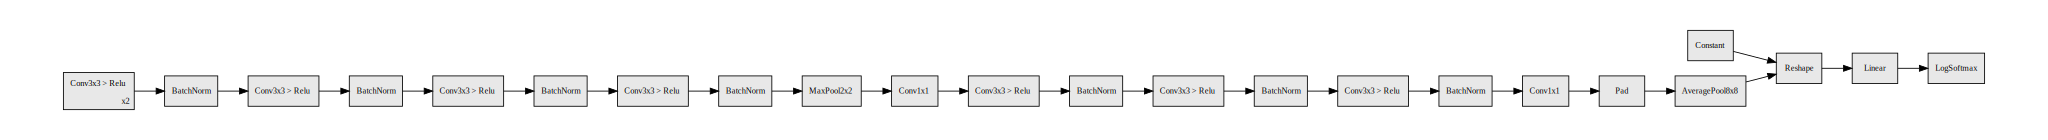

In [14]:

import hiddenlayer as hl
hl.build_graph(model, (torch.zeros([1, 1, 28, 28]).to('cuda')))